In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00


In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

## 1. Data preparation


### 1.1 Load data

In [4]:
from datasets import load_dataset
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [5]:
dataset = dataset.remove_columns(['id', 'chunk_tags', 'ner_tags'])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3453
    })
})

In [6]:
dataset_train = dataset["train"]
dataset_val = dataset["validation"]
dataset_test = dataset["test"]

Tokenizer: "bert-base-uncased"

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 113

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
class PosTagging_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer):
        super().__init__()
        self.tokens = dataset["tokens"]
        self.tags = dataset["pos_tags"]
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.dataset)

    def pad_and_truncate(self, sequence_token, sequence_label):
        pad_id = self.tokenizer.pad_token_id
        if len(sequence_token) < self.max_len:
            padded_sequence_token = sequence_token + [pad_id] * (self.max_len - len(sequence_token))
            padded_sequence_label = sequence_label + [47] * (self.max_len - len(sequence_label))
        else:
            padded_sequence_token = sequence_token[:self.max_len]
            padded_sequence_label = sequence_label[:self.max_len]

        return torch.tensor(padded_sequence_token), torch.tensor(padded_sequence_label)

    def __getitem__(self, idx):
        input_token = self.tokens[idx]
        label_token = self.tags[idx]

        input_token = self.tokenizer.convert_tokens_to_ids(input_token)
        input_ids, labels = self.pad_and_truncate(input_token, label_token)

        return input_ids, labels



get ids and labels from data tokens

In [9]:
train_set = PosTagging_Dataset(dataset_train, tokenizer)
val_set = PosTagging_Dataset(dataset_val, tokenizer)
test_set = PosTagging_Dataset(dataset_test, tokenizer)

In [10]:
from torch.utils.data import DataLoader
batch_size = 512

train_loader = DataLoader(train_set, batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)

##2. Model

In [11]:
emb_dim = 512
hidden_size = 512
vocab_size = len(tokenizer)
num_classes = 47+1

In [12]:
import torch.nn.functional as F

class POS_Model(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.fc1 = nn.Linear(emb_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.permute(0, 2, 1)


In [13]:
from torchinfo import summary

In [14]:
input_data = torch.randint(low = 0, high=vocab_size-1, size=(512, 113))
model = POS_Model(num_classes)
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
POS_Model                                [512, 48, 113]            --
├─Embedding: 1-1                         [512, 113, 512]           15,627,264
├─Linear: 1-2                            [512, 113, 512]           262,656
├─Linear: 1-3                            [512, 113, 1024]          525,312
├─Linear: 1-4                            [512, 113, 48]            49,200
Total params: 16,464,432
Trainable params: 16,464,432
Non-trainable params: 0
Total mult-adds (G): 8.43
Input size (MB): 0.46
Forward/backward pass size (MB): 970.13
Params size (MB): 65.86
Estimated Total Size (MB): 1036.45

##3. Evaluate

In [15]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total += (labels!=47).sum().item()
        test_loss += loss.item()
        correct += torch.multiply(predicted == labels, labels!=47).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

##4. Train

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index=47)

In [17]:
def train_model(model):
    hist = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    model.to(device)
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += (labels!=47).sum().item()
            running_correct += torch.multiply(predicted == labels, labels!=47).sum().item()

            loss.backward()
            optimizer.step()
        epoch_loss =  running_loss / len(train_loader)
        epoch_accuracy = 100* running_correct / total
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        hist["train_loss"].append(epoch_loss)
        hist["train_accuracy"].append(epoch_accuracy)
        hist["val_loss"].append(val_loss)
        hist["val_accuracy"].append(val_accuracy)

    return hist

In [18]:
print(f"Training FC model")
hist = train_model(model)

Training FC model
Epoch [1/50], Loss: 1.7634, Accuracy: 56.25%, Val loss: 1.1878, Val Accuracy: 68.07%
Epoch [2/50], Loss: 0.9943, Accuracy: 73.53%, Val loss: 0.8982, Val Accuracy: 76.83%
Epoch [3/50], Loss: 0.7995, Accuracy: 79.04%, Val loss: 0.7883, Val Accuracy: 79.86%
Epoch [4/50], Loss: 0.7141, Accuracy: 81.37%, Val loss: 0.7366, Val Accuracy: 81.18%
Epoch [5/50], Loss: 0.6693, Accuracy: 82.65%, Val loss: 0.7096, Val Accuracy: 81.94%
Epoch [6/50], Loss: 0.6463, Accuracy: 83.23%, Val loss: 0.7030, Val Accuracy: 82.30%
Epoch [7/50], Loss: 0.6320, Accuracy: 83.63%, Val loss: 0.6864, Val Accuracy: 82.67%
Epoch [8/50], Loss: 0.6235, Accuracy: 83.82%, Val loss: 0.6888, Val Accuracy: 82.71%
Epoch [9/50], Loss: 0.6168, Accuracy: 83.92%, Val loss: 0.6827, Val Accuracy: 82.77%
Epoch [10/50], Loss: 0.6126, Accuracy: 84.01%, Val loss: 0.6836, Val Accuracy: 82.82%
Epoch [11/50], Loss: 0.6097, Accuracy: 84.07%, Val loss: 0.6811, Val Accuracy: 82.88%
Epoch [12/50], Loss: 0.6072, Accuracy: 84.10%

##5. Plot results

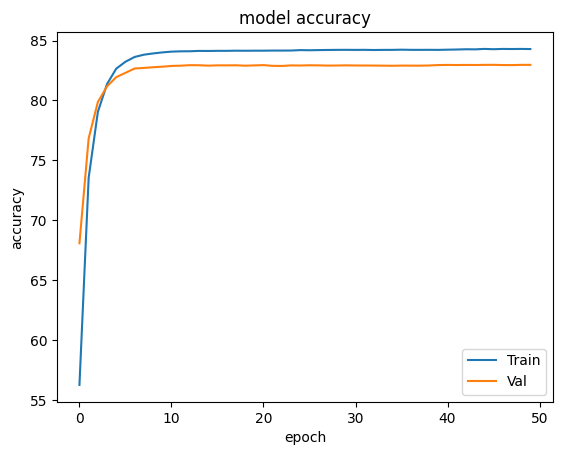

In [19]:
import matplotlib.pyplot as plt

plt.plot(hist['train_accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Val')


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val' ], loc='lower right')
plt.show()